# Session 3 - User Relevance Feedback

## 1 Document Relevance

In this sesion we are going to implement a pseudo user relevance feedback on top of ElasticSearch

One possibility that we have not used from the query results of ElasticSeach is the score computed as the relevance of the document respect to the terms of a query.

You have the script `SearchIndexWeights.py` that allows searching for keywords in an index just like we do in any seach engine (like Google search or Bing).

This script returns a limited number of hits and also shows the score of the documents (the documents are sorted by its score)

**Read the first section** of the session documentation and play a little bit with the documents that you have in the `news` index.

In [1]:
#from elasticsearch import Elasticsearch
#from elasticsearch_dsl import Search
#from elasticsearch_dsl.query import Q
#
#
#client = Elasticsearch()
#s = Search(using=client, index='news')
#
#
#q = Q('query_string',query='toronto')  # Feel free to change the word
#
#s = s.query(q)
#response = s[0:3].execute()
#for r in response:  # only returns a specific number of results
#    print('ID= %s SCORE=%s' % (r.meta.id,  r.meta.score))
#    print('PATH= %s' % r.path)
#    print('TEXT: %s' % r.text[:50])
#    print('-----------------------------------------------------------------')

***

## 2 Rocchio's Rule


For implementing the relevance we are going to use the Rocchio's rule. We are going to extend the query for a number of interations using the terms in the more relevant documents that are retrieved.

As is described in the session documentation you will need to write a scripts that given a query, repeats a number ($nrounds$) of times:

1. Obtain the $k$ more relevant documents
2. Compute a new query using the current query and the terms of the $k$ documents

The Rocchio's rule involves computing the folowing:

$$Query' = 	\alpha \times Query + \beta \times \frac{d_1 + d_2 + \cdots + d_k}{k}$$

So we have different parameters to play with:

1. The number of rounds ($nrounds$)
2. The number of relevand documents ($k$)
3. The parameters of the Rocchio's rule ($\alpha$ and $\beta$)
4. The numbeer of terms in the recomputed query ($R$)

**Read the documentation** and pay attention specially to how you have to build the query that you pass to ElasticSearch to include thw weights computed by the Rocchio's rule.

Think that some of the elements that you need for this part are functions that you programmed already as part of the past session assignment.

**Pay attention** to the documentation that you have to deliver for this session.



In [2]:
#!pip install elasticsearch
#!pip install elasticsearch_dsl
#!pip install numpy
#!pip install matplotlib

In [3]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl.query import Q
from elasticsearch.client import CatClient
from elasticsearch.exceptions import NotFoundError
import argparse
import numpy as np
import operator
import matplotlib.pyplot as plt

client = Elasticsearch( hosts=['http://localhost:9200'], request_timeout=1000)

/tmp/ipykernel_4488/3739133261.py:4: DeprecationWarning: Importing from the 'elasticsearch.client' module is deprecated. Instead use 'elasticsearch' module for importing the client.
  from elasticsearch.client import CatClient


Añadimos todas las clases necesarias para hacer el calculo de los valores

In [4]:
def doc_count(client, index):
    """
    Returns the number of documents in an index

    :param client:
    :param index:
    :return:
    """
    return int(CatClient(client).count(index=[index], format='json')[0]['count'])

def search(s,query, nhits):
    q = Q('query_string',query=query[0])
    for i in range(1, len(query)):
        q &= Q('query_string',query=query[i])
    s = s.query(q)
    response = s[0:nhits].execute()
    return response

def document_term_vector(client, index, doc_id):
    termvector = client.termvectors(index=index, id=doc_id, fields=['text'],
                                            positions=False, term_statistics=True)
    file_td = {}
    file_df = {}
    if 'text' in termvector['term_vectors']:
        for t in termvector['term_vectors']['text']['terms']:
            file_td[t] = termvector['term_vectors']['text']['terms'][t]['term_freq']
            file_df[t] = termvector['term_vectors']['text']['terms'][t]['doc_freq']
    return sorted(file_td.items()), sorted(file_df.items())

def toTFIDF(client, index, doc_id):
    file_tv, file_df = document_term_vector(client, index, doc_id)
    max_freq = max([f for _, f in file_tv])
    dcount = doc_count(client, index)
    tfidfw = {}
    for (t, w),(_, df) in zip(file_tv, file_df):
        tf = w / max_freq
        idf = np.log2(dcount / df)
        tfidfw[t] = ((tf * idf))
    
    return normalize(tfidfw)

def normalize(tw):
    norm = np.sqrt(sum([w * w for w in tw.values()]))
    return {t: w / norm for t, w in tw.items()}


def rocchio_update(query_vector, doc_vectors, alpha, beta, k,r):
    old_query = {term: query_vector.get(term,0)*alpha for term in set(query_vector)}
    doc_vectors = {term: doc_vectors.get(term,0)*beta/k for term in set(doc_vectors)}
    new_query = {}
    new_query = {term: doc_vectors.get(term, 0) + old_query.get(term, 0) for term in set(doc_vectors) | set(old_query)}
    new_query = sorted(new_query.items(), key=operator.itemgetter(1), reverse = True) 
    new_query = new_query[:r]
    return dict((term, val) for (term, val) in new_query) 

def queryToDict(query):
    query_dict = {}
    for elem in query:
        if '^' in elem:
            key, value = elem.split('^')
            value = float(value)
        else:
            key = elem
            value = 1.0
        query_dict[key] = value
        
    return normalize(query_dict)

def dictToquery(di):
    query = []
    for elem in di:
        q = elem + '^' + str(di[elem])
        query.append(q)
    return query

def query_to_string(query_vector):
    return ' '.join([f"{term}^{weight}" for term, weight in query_vector.items()])




Experimentamos con R, hasta 50 valores

In [5]:
index = 'news'

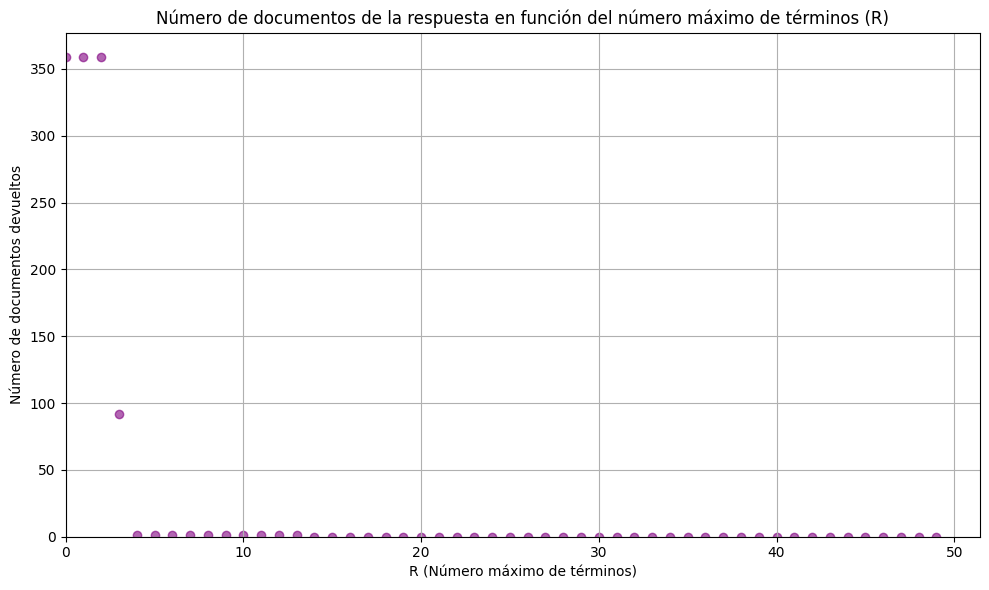

In [ ]:
queryInitial = ['Toronto'] # Siente libre de cambiar la query, ejemplo: ['Toronto', 'nyc^2']
nround = 1
k = 100
R = 50
alpha = 1
beta = 0.1
nhits = 1000 
try:
    s = Search(using=client, index=index)
    response_initial = search(s, queryInitial, k)
    responses = {}
    responses[0] = response_initial.hits.total['value']
    if queryInitial is not None:
        for r in range(1,R):
            query = queryInitial
            response = response_initial
            for _ in range(nround):
                query_vector = queryToDict(query)
                doc_vectors = {}
                for res in response:
                    file_tw = toTFIDF(client, index, res.meta.id)
                    doc_vectors = {t: doc_vectors.get(t,0) + file_tw.get(t,0) for t in set(file_tw) | set(doc_vectors)}   
                
                dictQuuery = rocchio_update(query_vector, doc_vectors, alpha, beta, k, r)
                query = dictToquery(dictQuuery)
            
            response = search(s, query, k)
            responses[r] = response.hits.total['value']
    else:
        print('No query parameters passed')
except NotFoundError:
    print(f'Index {index} does not exists')


# Datos
rounds = list(responses.keys())
total_documents = list(responses.values())

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.scatter(rounds, total_documents, color='purple', alpha=0.6)
plt.title("Número de documentos de la respuesta en función del número máximo de términos (R)")
plt.xlabel("R (Número máximo de términos)")
plt.ylabel("Número de documentos devueltos")

plt.xlim(left=0)
plt.ylim(bottom=0)

plt.grid(True)
plt.tight_layout()
plt.show()

Vemos como modifica la query conforme el valor de alpha aumenta

In [14]:
queryInitial = ['Toronto^3', 'detroit^5'] # Siente libre de cambiar la query, ejemplo: ['Toronto', 'nyc^2']nround = 10
nrounds = 4
k = 1000
r = 4
beta = 0.1
try:
    s = Search(using=client, index=index)
    response_initial = search(s, queryInitial, k)
    queries = {}
    queries[0] = queryInitial 
    if queryInitial is not None:
        for alpha in [0.5, 1.0, 2.0,5.0,10.0]:
            query = queryInitial
            response = response_initial
            for _ in range(nrounds):
                query_vector = queryToDict(query)
                doc_vectors = {}
                for res in response:
                    file_tw = toTFIDF(client, index, res.meta.id)
                    doc_vectors = {t: doc_vectors.get(t,0) + file_tw.get(t,0) for t in set(file_tw) | set(doc_vectors)}   
                
                dictQuuery = rocchio_update(query_vector, doc_vectors, alpha, beta, k, r)
                query = dictToquery(dictQuuery)
            
            response = search(s, query, k)
            queries[alpha] = query
        for alpha, query_vector in queries.items():
            print(f'Alpha = {alpha}: {query_vector}')
    else:
        print('No query parameters passed')
except NotFoundError:
    print(f'Index {index} does not exists')

Alpha = 0: ['Toronto^3', 'detroit^5']
Alpha = 0.5: ['detroit^0.4304103206386599', 'Toronto^0.25601142280020933', 'toronto^0.0030240707086244068', 'leafs^0.002147765640547639']
Alpha = 1.0: ['detroit^0.8591621575182073', 'Toronto^0.5132598261652292', 'toronto^0.0030277226507837178', 'leafs^0.002150359335155595']
Alpha = 2.0: ['detroit^1.716657779357031', 'Toronto^1.0277558521832004', 'toronto^0.0030295455148936445', 'leafs^0.002151653975817112']
Alpha = 5.0: ['detroit^4.289138177084453', 'Toronto^2.5712432833148178', 'toronto^0.0030306382233935324', 'leafs^0.0021524300429125337']
Alpha = 10.0: ['detroit^8.576603346329208', 'Toronto^5.143722115818761', 'toronto^0.00303100228991672', 'leafs^0.0021526886114596076']


Vemos como se modifica la query conforme el valor de betha aumenta

In [19]:
queryInitial = ['Toronto', 'nyc','water'] # Siente libre de cambiar la query, ejemplo: ['Toronto', 'nyc^2']nround = 10
nrounds = 5
k = 1000
r = 5
alpha = 0.1
try:
    s = Search(using=client, index=index)
    response = search(s, queryInitial, k)
    queries = {}
    queries[0] = queryInitial 
    if queryInitial is not None:
        for beta in [0.5, 1.0, 2.0,5.0,10.0]:
            query = queryInitial
            for _ in range(nrounds):
                query_vector = queryToDict(query)
                doc_vectors = {}
                for res in response:
                    file_tw = toTFIDF(client, index, res.meta.id)
                    doc_vectors = {t: doc_vectors.get(t,0) + file_tw.get(t,0) for t in set(file_tw) | set(doc_vectors)}   
                
                dictQuuery = rocchio_update(query_vector, doc_vectors, alpha, beta, k, r)
                query = dictToquery(dictQuuery)
                response = search(s, query, k)
            
            response = search(s, query, k)
            queries[beta] = query
        for beta, query_vector in queries.items():
            print(f'Beta = {beta}: {query_vector}')
    else:
        print('No query parameters passed')
except NotFoundError:
    print(f'Index {index} does not exists')

Beta = 0: ['Toronto', 'nyc', 'water']
Beta = 0.5: ['water^0.05875763528832555', 'nyc^0.057368773990973176', 'Toronto^0.057343406464546255', 'mwra^0.001614640987491713', 'dept^0.0006715818530680544']
Beta = 1.0: ['water^0.05975773707381172', 'nyc^0.05698993488691345', 'Toronto^0.056939381030128404', 'mwra^0.0032177488599866196', 'dept^0.0013383667074217168']
Beta = 2.0: ['water^0.061690610767554936', 'nyc^0.05619701267036368', 'Toronto^0.05609667220067452', 'mwra^0.006386662709545601', 'dept^0.00265642134110589']
Beta = 5.0: ['water^0.06696073337674409', 'nyc^0.053581805115861345', 'Toronto^0.053337439233631836', 'mwra^0.015553868467580886', 'dept^0.006469361231849913']
Beta = 10.0: ['water^0.07411650733225643', 'nyc^0.04872480932348131', 'Toronto^0.048261030419504275', 'mwra^0.02951948940123593', 'dept^0.01227811850887166']


Ahora miraremos como cambia el valor de acuerdo al numero de nrounds

In [9]:
queryInitial = ['Toronto'] # Siente libre de cambiar la query, ejemplo: ['Toronto', 'nyc^2']
k = 1000
r = 4
alpha = 1
beta = 0.1
nround = 100

average_weights_per_round = []
#std_dev_weights_per_round = []
try:
    s = Search(using=client, index=index)
    response = search(s, queryInitial, k)
    weights = {}
    if queryInitial is not None:
        query = queryInitial
        for i in range(1,nround):
            query_vector = queryToDict(query)
            doc_vectors = {}
            for res in response:
                file_tw = toTFIDF(client, index, res.meta.id)
                doc_vectors = {t: doc_vectors.get(t,0) + file_tw.get(t,0) for t in set(file_tw) | set(doc_vectors)}   
            
            dictQuuery = rocchio_update(query_vector, doc_vectors, alpha, beta, k, r)
            query = dictToquery(dictQuuery)
            response = search(s, query, k)
            weights = list(query_vector.values())
            average_weights_per_round.append(np.mean(weights))
            #std_dev_weights_per_round.append(np.std(weights))
    else:
        print('No query parameters passed')
except NotFoundError:
    print(f'Index {index} does not exists')

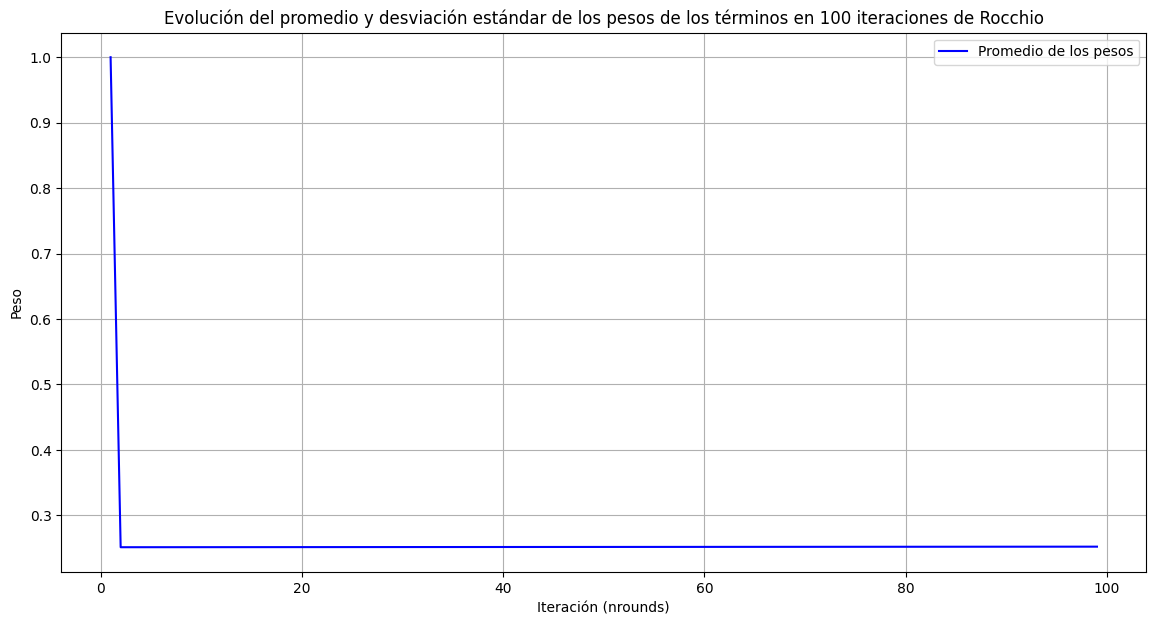

In [ ]:
# Graficar el promedio y la desviación estándar de los pesos
plt.figure(figsize=(14, 7))

# Promedio de los pesos
plt.plot(range(1, len(average_weights_per_round) + 1), average_weights_per_round, label="Promedio de los pesos", color='blue')

# Desviación estándar de los pesos
#plt.plot(range(1, len(std_dev_weights_per_round) + 1), std_dev_weights_per_round, label="Desviación estándar de los pesos", color='orange')

plt.title("Evolución del promedio de los pesos de los términos en 100 iteraciones de Rocchio")
plt.xlabel("Iteración (nrounds)")
plt.ylabel("Peso")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

Ahora haremos para los valores de **K**

In [22]:
queryInitial = ['Toronto'] # Siente libre de cambiar la query, ejemplo: ['Toronto', 'nyc^2']
r = 4
alpha = 1
beta = 0.1
nround = 5
try:
    s = Search(using=client, index=index)
    documents_per_k = {}
    for k in range(1, 101):
        if queryInitial is not None:
            response = search(s, queryInitial, k)
            query = queryInitial
            for i in range(1,nround):
                query_vector = queryToDict(query)
                doc_vectors = {}
                for res in response:
                    file_tw = toTFIDF(client, index, res.meta.id)
                    doc_vectors = {t: doc_vectors.get(t,0) + file_tw.get(t,0) for t in set(file_tw) | set(doc_vectors)}   
                
                dictQuuery = rocchio_update(query_vector, doc_vectors, alpha, beta, k, r)
                query = dictToquery(dictQuuery)
            
            response = search(s, query, k)
            documents_per_k[k] = (response.hits.total['value'])
        
        else:
            print('No query parameters passed')
except NotFoundError:
    print(f'Index {index} does not exists')



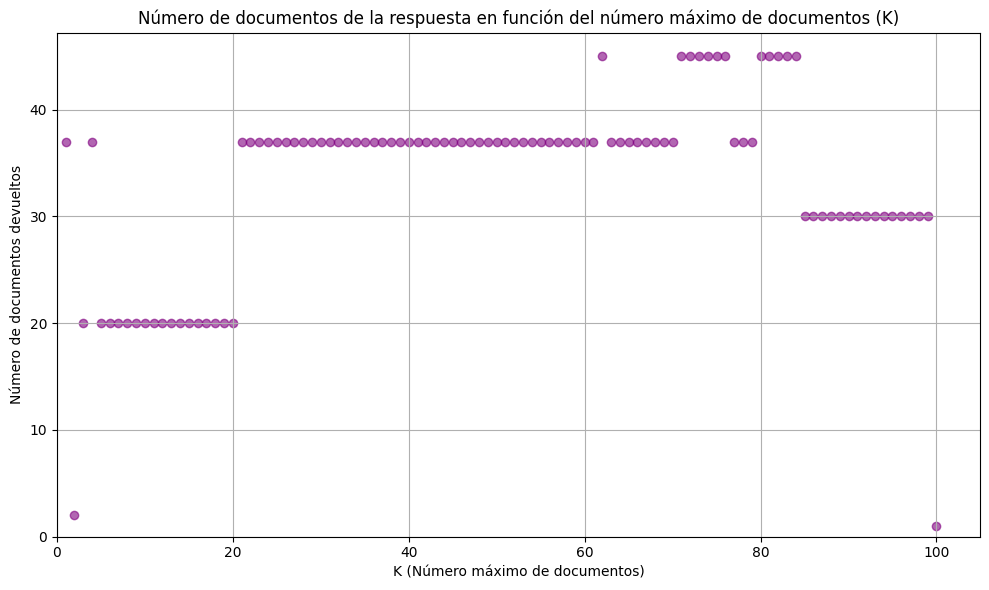

In [23]:

# Datos
ks = list(documents_per_k.keys())
total_documents = list(documents_per_k.values())

plt.figure(figsize=(10, 6))
plt.scatter(ks, total_documents, color='purple', alpha=0.6)
plt.title("Número de documentos de la respuesta en función del número máximo de documentos (K)")
plt.xlabel("K (Número máximo de documentos)")
plt.ylabel("Número de documentos devueltos")

plt.xlim(left=0)
plt.ylim(bottom=0) 

plt.grid(True)
plt.tight_layout()
plt.show()